# nmi | spring 2024
## lecture 20 : nonlinear


### 8.4 nonlinear partial differential equations


the implicit BDM method of section 8.1 will be the working example for nonlinear FDM, FEM.
</br>


#### 8.4.1 implicit newton solver


<b>burgers equation</b> is an elliptic equation named after jm burgers that is a simpliflied model of fluid flow, with visocity $D$. it is a typical nonlinear example and a benchmark for solvers.
</br></br>

discretize burgers as the heat equation was in section 8.1. denote approximate solution at $(x_i,t_i)$ by $w_{ij}$. let $M,N$ be number of total steps in $x,t$ directions. apply BD to $u_t$ and CD to other terms.
</br></br>

$$\frac{w_{ij} - w_{i,j-1}}{k} + w_{i,j}\frac{w_{i+1,j}-w_{i-1,j}}{2h} = \frac{D}{h^2}(w_{i+1,j}-2w_{ij}+w_{i-1,j})$$
</br>

$$\Downarrow$$
</br>

$$w_{ij} + \frac{k}{2h}w_{ij}(w_{i+1,j}-w_{i-1,j}) - \sigma(w_{i+1,j}-2w_{i,j}+w_{i-1,j}) - w_{i,j-1} = 0, \quad \sigma = \frac{Dk}{h^2}$$
</br>


bc of the quadratics, $w_{i+1,j},w_{ij},w_{i-1,j}$ cannot be solved explicitly or implicitly, so use multivariate newton (ch 2).
</br></br>

for one $j$ at a time, given time $j$, define $z_i =  w_{ij}$.
</br></br>

$$F_i(z_i,\dots,z_m) = z_i + \frac{k}{2h}z_i(z_{i+1} - z_{i-1}) - \sigma(z_{i+1} - 2z_9 + z_{i-1}) - w_{i,j-1} = 0$$
</br>

for $m$ unknowns $z_1,\dots,z_m$. oc $w_{i,j-1}$ is known. and first and last equations are replaced by boundary conditions. eg, for burgers
</br></br>

$$
\left\{
  \begin{array}
    u_t + uu_x = Du_{xx} \\
    u(x,0) = f(x), \quad x_l\le x\le x_r \\
    u(x_l,t) = l(t), \quad t\ge 0 \\
    u(x_r,t) = r(t), \quad t\ge 0 \\
    \\
    F_1(z_1,\dots,z_m) = z_1 - l(t_j) = 0 \\
    F_m(z_1,\dots,z_m) = z_m - r(t_j) = 0
  \end{array}
\right.
$$
</br>

ie, there are $m$ nonlinear algebraic equations in $m$ unknowns.
</br></br>

to apply multivariate newton, compute jacobian $DF(\vec{z}) = \frac{\partial \vec{F}}{\partial \vec{z}}$
</br></br>

$$
\begin{bmatrix}
  1 & 0 & \dots \\
  -\sigma-\frac{kz_2}{2h} & 1+2+\frac{k(z_3-z_1)}{2h} & -\sigma+\frac{kz_2}{2h} \\
  & -\sigma-\frac{kz_3}{2h} & 1+2+\frac{k(z_4-z_2)}{2h} & -\sigma+\frac{kz_3}{2h} \\
  & & \ddots & \ddots & \ddots \\
  & & & -\sigma-\frac{kz_{m-1}}{2h} & 1+2+\frac{k(z_m-z_{m-2})}{2h} & -\sigma+\frac{kz_{m-1}}{2h} \\
  & & & \dots & 0 & 1
\end{bmatrix}
$$
</br>

and solve for $z_i = w_{ij}$ by multivariate newton iteration
</br></br>

$$\vec{z}^{K+1} = \vec{z}^K - DF(\vec{z}^K)^{-1}F(\vec{z}^K).$$


##### example 12


use BDE with MNI to solve burgers.
</br></br>

$$
\left\{
  \begin{array} &
    u_t + uu_x = Du_{xx} \\
    u(x,0) = \frac{2D\beta\pi sin\pi x}{\alpha + \beta cos\pi x}, \quad 0\le x\le 1, \alpha = 5,\beta = 4 \\
    u(0,t) = 0, \quad t\ge 0 \\
    u(1,t) = 0, \quad t\ge 0 \\
  \end{array}
\right.
$$
</br>


###### code, matlab


[matlab online](https://matlab.mathworks.com)
</br>

```
% Program 07 Implicit Newton solver for Burgers equation
% input: space interval [xl,xr], time interval [tb,te],
% number of space steps M, number of time steps N
% output: solution w
% Example usage: w=burgers(0,1,0,2,20,40)
function w=burgers(xl,xr,tb,te,M,N)
  alf=5;bet=4;D=.05;
  f=@(x) 2*D*bet*pi*sin(pi*x)./(alf+bet*cos(pi*x));
  l=@(t) 0*t;
  r=@(t) 0*t;
  h=(xr-xl)/M; k=(te-tb)/N; m=M+1; n=N;
  sigma=D*k/(h*h);
  % initial conditions
  w(:,1)=f(xl+(0:M)*h)';
  w1=w;
  for j=1:n
    for it=1:3
      % Newton iteration
      DF1=zeros(m,m);DF2=zeros(m,m);
      DF1=diag(1+2*sigma*ones(m,1))+diag(-sigma*ones(m-1,1),1);
      DF1=DF1+diag(-sigma*ones(m-1,1),-1);
      DF2=diag([0;k*w1(3:m)/(2*h);0])-diag([0;k*w1(1:(m-2))/(2*h);0]);
      DF2=DF2+diag([0;k*w1(2:m-1)/(2*h)],1)...
        -diag([k*w1(2:m-1)/(2*h);0],-1);
      DF=DF1+DF2;
      F=-w(:,j)+(DF1+DF2/2)*w1;
      % Using Lemma 8.11
      DF(1,:)=[1 zeros(1,m-1)];
      % Dirichlet conditions for DF
      DF(m,:)=[zeros(1,m-1) 1];
      F(1)=w1(1)-l(j);F(m)=w1(m)-r(j); % Dirichlet conditions for F
      w1=w1-DF\F;
    end
    w(:,j+1)=w1;
  end
  % 3-D plot of solution w
  x=xl+(0:M)*h;t=tb+(0:n)*k;
  mesh(x,t,w')
end
```


###### code, python


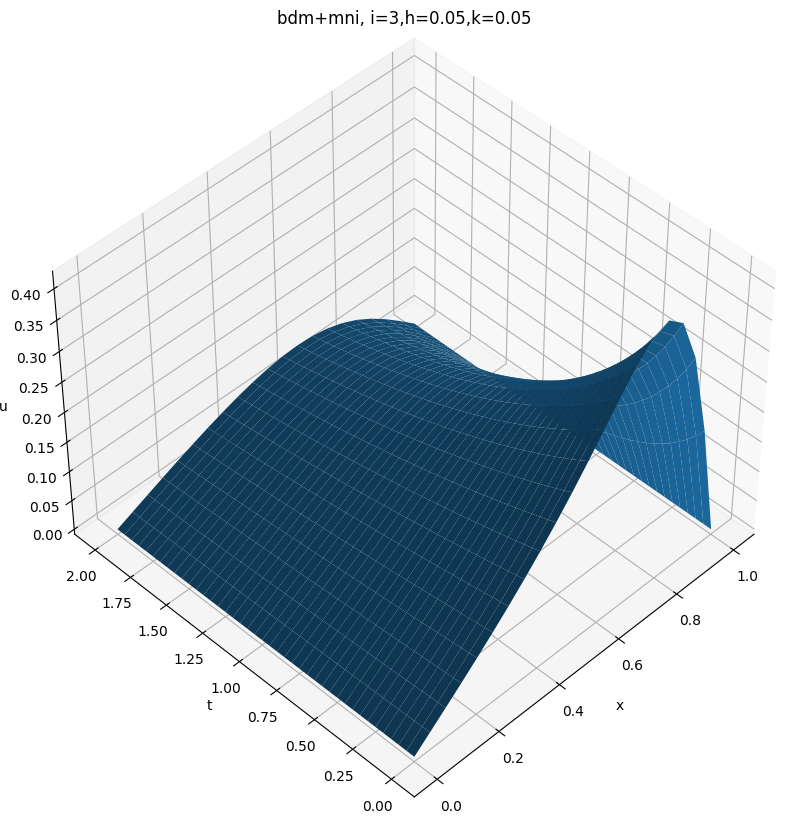

In [ ]:
# example 12 ~ program 07 BDM+MNI applied to burgers

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.set_printoptions(precision=4,suppress=True) # ~ matlab vs python

# bvp
F = lambda x: 2*D*BETA*np.pi*np.sin(np.pi*x)/(ALPHA+BETA*np.cos(np.pi*x))
BCL = lambda t: 0*t
BCR = lambda t: 0*t

# som parms
ALPHA,BETA,D = 5,4,0.05
imax = 3 # max multivate newtons iterations # value per sauer

# interval
x,t = [0,1],[0,2]
# subintervals, steps
M = 20
N = 40
h = (x[1]-x[0])/M
k = (t[1]-t[0])/N
# mesh
m = M+1  # interior points [1,m]
n = N    # time steps [1,n]; however, solution [0,n]
xs = np.linspace(x[0],x[1],M+1)
ts = np.linspace(t[0],t[1],N+1)
sigma = D*k/pow(h,2)

# approx soln
# initialize
ws = np.zeros((M+1,N+1)) # [0:M,0:N]
# ic
ws[:,0] = F(xs) # ic
w1 = np.copy(ws[:,0]) # hate this but just in case

for j in range(n):
  for i in range(imax+1): # mni
    # DF for interior
    DF1 = np.zeros((m,m))
    DF1.flat[0::m+1] = 1+2*sigma
    DF1.flat[1::m+1] = DF1.flat[m::m+1] = -sigma
    # lol whatever = better later
    DF2 = np.zeros((m,m))
    for i_df in range(1,m-1):
      DF2[i_df,i_df] = k*(w1[i_df+1]-w1[i_df-1])/(2*h)
      DF2[i_df,i_df-1] -= k*w1[i_df]/(2*h)
      DF2[i_df,i_df+1] += k*w1[i_df]/(2*h)
    DF = np.zeros((m,m))
    DF = DF1 + DF2

    F = np.zeros((m,1))
    F = -ws[:,j] + np.dot(DF1 + DF2/2,w1) # lemma 8.11
    # dirichlet for DF
    DF[  0,:] = [1 if bci ==   0 else 0 for bci in range(m)] # bc row 0
    DF[m-1,:] = [1 if bci == m-1 else 0 for bci in range(m)] # bc row m-1
    # dirichlet for F
    F[  0] = w1[  0] - BCL(j)
    F[m-1] = w1[m-1] - BCR(j)
    w1 = w1 - np.dot(np.linalg.inv(DF),F)
  ws[:,j+1] = w1

# plot some
if True:
  x,y = np.meshgrid(xs,ts,indexing='ij')
  fig,axs = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':'3d'})

  axs.set_title("bdm+mni, i=" + str(i) + ",h=" + str(h) + ",k=" + str(k))
  axs.plot_surface(x,y,ws)
  axs.set_xlabel("x")
  axs.set_ylabel("t")
  axs.set_zlabel("u")

  for angle in range(0,360):
    axs.view_init(elev=45,azim=225,roll=0)

  plt.show()



the matlab code really looks like the below. not like that chumpy plot facing a way im not spinning python for.
</br>


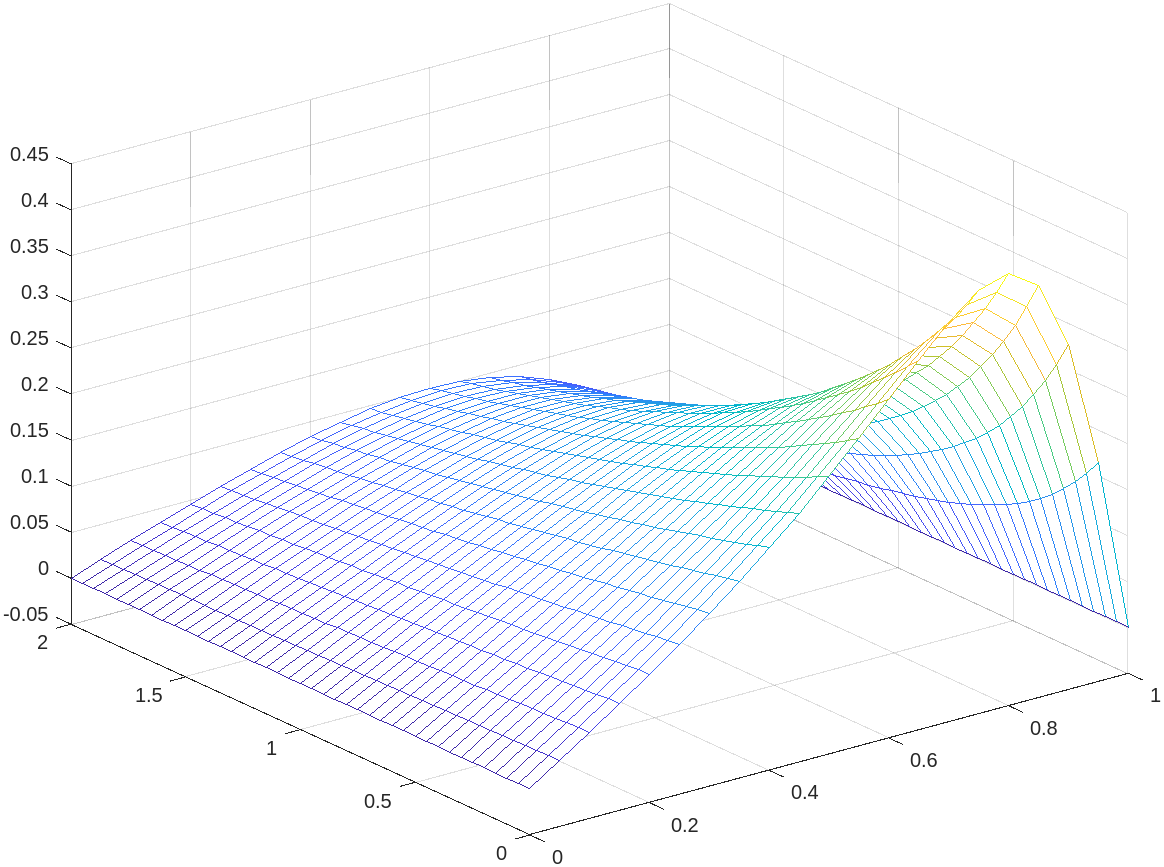

###### usw


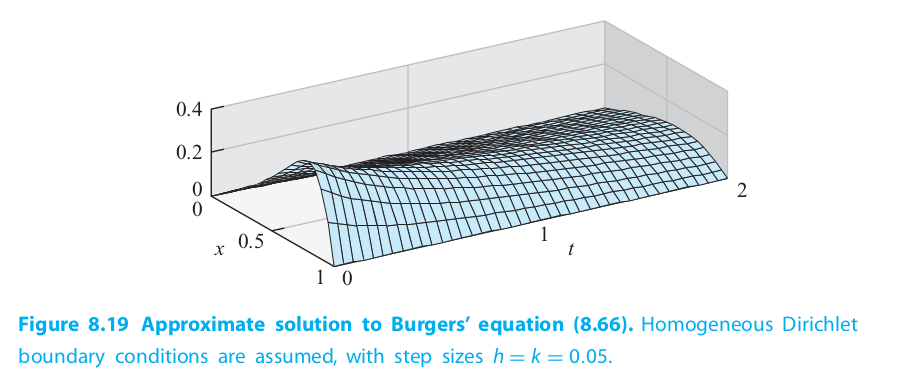

##### usw


consider polynomial $P(x_1,x_2,x_3) = x_1x_2x_3^2 + x_1^4$, which is called homogeneous of degree four since it consists entirely of degree four terms in $x_1,x_2,x_3$. the partial of $P$ contained in gradient
</br></br>

$$\nabla P = (x_2x_3^2 + 4x_1^3,x_1x_3^2,2x_1x_2x_3).$$
</br>

recover $P$ by multiplying gradient by the vector of variables with an extra multiple of its order, 4.
</br></br>

$$
\nabla P \cdot \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix}
= (x_2x_3^2 + 4x_1^3)x_1 + x_1x_3^2x_2 + 2x_1x_2x_3x_3 = 4x_1x_2x_3^2 + 4x_1^4 = 4P.
$$
</br>

in general, define polynomial $P(x_1,\dots,x_m)$ to be <b>homogeneous</b> of degree $d$ if
</br></br>

$$P(cx_1,\dots,cx_m) = c^dP(x_1,\dots,x_m), \quad\text{for all }c.$$
</br>


##### <b><font color=grey>lemma 11</font></b>


let $P(x_1,\dots,x_m)$ be homogeneous polynomial of degree $d$. then
</br></br>

$$
\nabla P \cdot \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} = dP.
$$
</br>


###### proof


differentiating $P(cx_1,\dots,cx_m) = c^dP(x_1,\dots,x_m)$ wrt $c$ yields
</br></br>

$$x_1P_{x_1}(cx_1,\dots,cx_m) + \dots + x_mP_{x_m}(cx_1,\dots,cx_m) = dc^{d-1}P(x_1,\dots,x_m).$$
</br>

evaluate at $c=1$. $\blacksquare$
</br>


##### usw


ie, code for PDEs with polynomials can be written compactly if like degrees grouped together.
</br></br>

for certain boundary conditions, an explicit solution for burgers equation is known. the solution to the dirichlet problem is
</br></br>

$$u(x,t) = \frac{2D\beta\pi e^{-D\pi^2t}sin\pi x}{\alpha + \beta e^{-D\pi^2 t}cos\pi x}.$$

ie, use that to measure accuracy of approximation per $h,k$. eg, $\alpha = 5,\beta=4, D=0.05$ at $x=\frac{1}{2}$ after one time step,
</br>


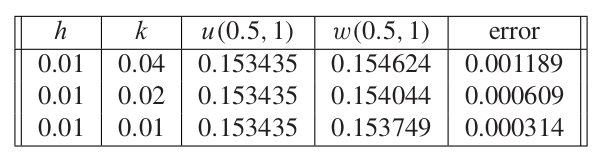

which shows a first-order decrease in error as a function of time step size $k$, as expected with BDM.
</br>


consider <b>reaction-diffusion equations</b>. r.a. fisher is a successor of darwin who helped create the foundations of modern statistics. <b>fishers equation</b> was originally derived to model how genes propagate.
</br></br>

$$u_t = \underbrace{Du_{xx}}_{\text{diffusion}} + \underbrace{f(u)}_{\text{reaction}}$$
</br>

where $f(u)$ is a polynomial in $u$. if homogeneous neumann boundary conditions are used, the constant - ie, equilibrium - state $u(x,t) \equiv C$ is the solution whenever $f(C) = 0$. the equilibrium state is stable if $f(C) < 0$. ie, nearby solutions tend toward the equilibrium state.
</br>


##### example 13


use BDE with MNI to solve fishers equation with homogeneous neumann boundary conditions
</br></br>

$$
\left\{
  \begin{array}{l}
    u_t = Du_{xx} + u(1-u) \\
    u(x,0) = sin\pi x, \quad 0\le x\le 1 \\
    u_x(0,t) = 0, \quad t\ge 0 \\
    u_x(1,t) = 0, \quad t\ge 0
  \end{array}
\right.
$$
</br>

note $f(u) = u(1-u) \Rightarrow f'(u) = 1 - 2u$. ie, equilibium $u=0$ satisfies $f'(0)=1$ and equilibrium $u=1$ satisfies $f'(1)=-1$. therefore, solutions will tend towards equilibrium $u=1$.
</br>


similar to discretization for burgers,
</br></br>

$$\frac{w_{ij}-w_{i,j-1}}{k} = \frac{D}{h^2}(w_{i+1,j}-2w_{ij}+w_{i-1,j})+w_{ik}(1-w_{ij})$$
</br>

$$\Downarrow$$
</br>

$$(1 + 2\sigma - k(1-w_{ij}))w_{ij} - \sigma(w_{i+1,j}+w_{i-1,j}) - w_{i,j-1} = 0$$
</br>

$$\Downarrow$$
</br>

$$F_i(z_1,\dots,z_m) = (1 + 2\sigma - k(1-z_i))z_i - \sigma(z_{i+1}+z_{i-1}) - w_{i,j-1} = 0, \quad z_i = w_{ij}, \text{time step } j$$
</br>

$$\Downarrow$$
</br>

\begin{align}
  F_1(z_1,\dots,z_m) &= \frac{-3z_0 + 4z_1 - z_2}{2h} = 0 \\
  F_m(z_1,\dots,z_m) &= \frac{-z_{m-2} + 4z_{m-1} - 3z_m}{-2h} = 0
\end{align}
</br>

$$\Downarrow$$
</br>

$$
DF =
\begin{bmatrix}
  -3 & 4 & -1 \\
  -\sigma & 1 + 2\sigma - k + 2kz_2 & -\sigma \\
  & -\sigma & 1 + 2\sigma - k + 2kz_3 & -\sigma \\
  & & \ddots & \ddots & \ddots \\
  & & & -\sigma & 1 + 2\sigma - k + 2kz_{m-1} & -\sigma \\
  & & & -1 & 4 & -3
\end{bmatrix}
$$
</br>


modify eg 8.12 code for $F,DF$, usw.
</br>


###### code, matlab



fyi, sauers matlab fragment skims right over $f(x)$ and it sure doesnt seem to be $u(x,0)$, but it ~is as its captioned under fig 8.20. <b>he chose the second equilibrium to plot but left his code at his first choice.</b>
</br></br>

<i>well, i guess its alright since his text hasnt had much in the way of actual errors. i guess.</i>
</br></br>

[matlab online](https://matlab.mathworks.com)
</br>

```
% Program 07 Implicit Newton solver for Burgers equation
% input: space interval [xl,xr], time interval [tb,te],
% number of space steps M, number of time steps N
% output: solution w
% Example usage: w=burgers(0,1,0,2,20,40)
function w=burgers(xl,xr,tb,te,h,k)
  D=1;
  %f=@(x) sin(pi*x); % eg 8.13 but LOLWUT it isnt fig 8.20!!
  f=@(x) 0.5 + 0.5*cos(pi*x); % fig 8.20a
  %f=@(x) 1.5 + 0.5*cos(pi*x); % fig 8.20.b
  l=@(t) 0*t;
  r=@(t) 0*t;
  M=round((xr-xl)/h); N=round((te-tb)/k);
  %h=(xr-xl)/M; k=(te-tb)/N;
  m=M+1; n=N;
  sigma=D*k/(h*h);
  % initial conditions
  w(:,1)=f(xl+(0:M)*h)';
  w1 = w;
  for j=1:n
    % Newton iteration
    for it=1:3
      % Using Lemma 8.11
      DF1=diag(1-k+2*sigma*ones(m,1))+diag(-sigma*ones(m-1,1),1);
      DF1=DF1+diag(-sigma*ones(m-1,1),-1);
      DF2=diag(2*k*w1);
      DF=DF1+DF2;
      F=-w(:,j)+(DF1+DF2/2)*w1;
      % Neumann conditions for DF,F
      DF(1,:)=[-3 4 -1 zeros(1,m-3)];F(1)=DF(1,:)*w1-l(j);
      DF(m,:)=[zeros(1,m-3) -1 4 -3];F(m)=DF(m,:)*w1-r(j);
      w1=w1-DF\F;
    end
    w(:,j+1)=w1;
  end
  % 3-D plot of solution w
  x=xl+(0:M)*h;t=tb+(0:n)*k;
  mesh(x,t,w')
end
```



###### code, python


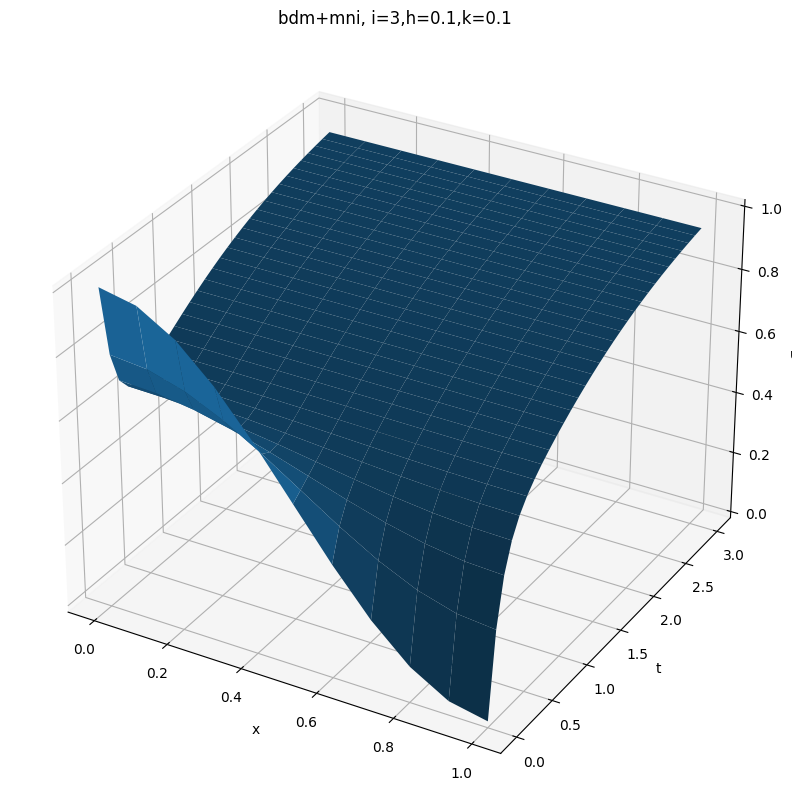

In [ ]:
# example 13 ~ program 07 BDM+MNI applied to fishers

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.set_printoptions(precision=4,suppress=True) # ~ matlab vs python

# bvp
F = lambda x: 0.5 + 0.5*np.cos(np.pi*x) # fig 8.20.a
# F = lambda x : 1.5 + 0.5*np.cos(np.pi*x) # fig 8.20.b
BCL = lambda t: 0*t
BCR = lambda t: 0*t

# som parms
D = 1
imax = 3 # max multivate newtons iterations # value per sauer

# interval
x,t = [0,1],[0,3]
# subintervals, steps
h = 0.1
k = 0.1
M = round((x[1]-x[0])/h)
N = round((t[1]-t[0])/k)
# mesh
m = M+1  # interior points [1,m]
n = N    # time steps [1,n]; however, solution [0,n]
xs = np.linspace(x[0],x[1],M+1)
ts = np.linspace(t[0],t[1],N+1)
sigma = D*k/pow(h,2)

# approx soln
# initialize
ws = np.zeros((M+1,N+1)) # [0:M,0:N]
# ic
ws[:,0] = F(xs) # ic
w1 = np.copy(ws[:,0]) # hate this but just in case

for j in range(n):
  for i in range(imax+1): # mni
    # DF for interior
    DF1 = np.zeros((m,m))
    DF1.flat[0::m+1] = 1-k+2*sigma
    DF1.flat[1::m+1] = DF1.flat[m::m+1] = -sigma
    # lol whatever = better later
    DF2 = np.zeros((m,m))
    for i_df in range(1,m-1):
      DF2[i_df,i_df] = 2*k*w1[i_df]
    DF = np.zeros((m,m))
    DF = DF1 + DF2

    F = np.zeros((m,1))
    F = -ws[:,j] + np.dot(DF1 + DF2/2,w1) # lemma 8.11
    # neumann for DF
    DF[  0,:] = [-3 if bci == 0   else 4 if bci == 1   else -1 if bci == 2   else 0 for bci in range(m)] # bc row 0
    DF[m-1,:] = [-1 if bci == m-3 else 4 if bci == m-2 else -3 if bci == m-1 else 0 for bci in range(m)] # bc row m-1
    # neumann for F
    F[  0] = np.dot(DF  [0,:],w1) - BCL(j)
    F[m-1] = np.dot(DF[m-1,:],w1) - BCR(j)
    w1 = w1 - np.dot(np.linalg.inv(DF),F)
  ws[:,j+1] = w1

# plot some
if True:
  x,y = np.meshgrid(xs,ts,indexing='ij')
  fig,axs = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':'3d'})

  axs.set_title("bdm+mni, i=" + str(i) + ",h=" + str(h) + ",k=" + str(k))
  axs.plot_surface(x,y,ws)
  axs.set_xlabel("x")
  axs.set_ylabel("t")
  axs.set_zlabel("u")

  #for angle in range(0,360):
  #  axs.view_init(elev=45,azim=225,roll=0)

  plt.show()



###### usw

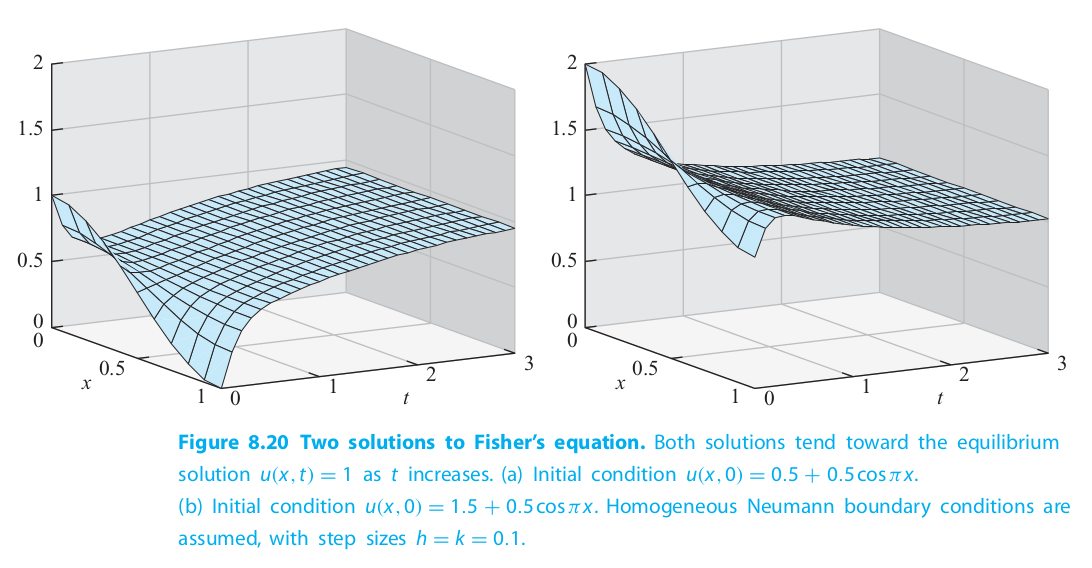

#### 8.4.2 nonlinear equations in two space dimensions


like section 8.4.1, use implicit backward difference method and newton iteration but for nonlinearity also translate the mesh using the methods from 8.3.1.
</br>


##### example 14


apply BDM with MNI to fishers equation on unit square $[0,1]\times[0,1]$
</br></br>

$$
\left\{
  \begin{array}{l}
    u_t = D\Delta u + u(1-u) \\
    u(x,y,0) = 2 + cos\pi x\cdot cos\pi y, \quad 0\le x,y\le 1 \\
    u_{\vec{n}}(x,y,t) = 0, \quad \text{on boundary, } t\ge 0
  \end{array}
\right.
$$
</br>

where $D$ is diffusion coefficient, $u_{\vec{n}}$ is directional derivative in the outward normal condition. assume neumann (ie, no-flux) boundary conditions.
</br>


$i,j$ represent spacial coordinates $x,y$. $M$ steps along $x, N$ steps along $y$ with step sizes $h = \frac{x_r-x_l}{M},k = \frac{y_t-y_b}{N}$. discretized equations at nonboundary grid points for $1<i<m=M+1$, $1<j<n=N+1$
</br></br>

$$\frac{w_{ij}^t-w_{ij}^{t-\Delta t}}{\Delta t} = \frac{D}{h^2}(w_{i+1,j}^t-2w_{ij}^t+w_{i-1,j}^t)+ \frac{D}{k^2}(w_{i,j+1}^t-2w_{ij}^t+w_{i,j-1}^t)+w_{ij}^t(1-w_{ij}^t)$$
</br>

$$\Downarrow \quad F_{ij}(w^t) = 0$$
</br>

$$\left( \frac{1}{\Delta t}+\frac{2D}{h^2}+\frac{2D}{k^2}-1 \right) w_{ij}^t-\frac{D}{h^2}w_{i+1,j}^t-\frac{D}{h^2}w_{i-1,j}^t-\frac{D}{k^2}w_{i,j+1}^t-\frac{D}{k^2}w_{i,j-1}^t-(w_{ij}^t)^2-\frac{w_{ij}^{t-\Delta t}}{\Delta t} = 0$$
</br>


solve $F_{ij}$ implicitly and use multivariate newtons bc nonlinear. flatten 2D system with $v_{i+(j-1)m} = w_{ij}$ and run it through the machine.
</br></br>

\begin{align}
  DF_{i+(j-1)m.i+(j-1)m} &= \left( \frac{1}{\Delta t}+\frac{2D}{h^2}+\frac{2D}{k^2}-1 \right) + 2w_{ij} \\
  DF_{i+(j-1)m,i+1+(j-1)m} &= -\frac{D}{h^2} \\
  DF_{i+(j-1)m,i-1+(j-1)m} &= -\frac{D}{h^2} \\
  DF_{i+(j-1)m,i+jm} &= -\frac{D}{k^2} \\
  DF_{i+(j-1)m,i+(j-2)m} &= -\frac{D}{k^2}
\end{align}
</br>

for interior points. for points governed by neumann boundary conditions,
</br></br>

\begin{align}
  \text{bottom} &\quad \frac{3w_{ij}-4w_{i,j+1}+w_{i,j+2}}{2k}=0,\quad j=1,1\le i\le m \\
  \text{top} &\quad \frac{3w_{ij}-4w_{i,j-1}+w_{i,j-2}}{2k}=0,\quad j=n,1\le i\le m \\
  \text{left} &\quad \frac{3w_{ij}-4w_{i+1,j}+w_{i+2,j}}{2h}=0,\quad i=1,1\le j\le n \\
  \text{right} &\quad \frac{3w_{ij}-4w_{i-1,j}+w_{i-2,j}}{2h}=0,\quad i=m,1\le j\le n \\
  \\
  &\quad \Downarrow \\
  \\
  \text{bottom} &\quad DF_{i+(j-1)m,i+(j-1)m} = 3, \\
  &\quad DF_{i+(j-1)m,i+jm}=-4, \\
  &\quad DF_{i+(j-1)m,i+(j+1)m} = 1, \\
  &\quad b_{i+(j-1)m} = 0, \quad j=1,1\le i\le m; \\
  \text{top} &\quad DF_{i+(j-1)m,i+(j-1)m} = 3, \\
  &\quad DF_{i+(j-1)m,i+(j-2)m}=-4, \\
  &\quad DF_{i+(j-1)m,i+(j-3)m} = 1, \\
  &\quad b_{i+(j-1)m} = 0, \quad j=n,1\le i\le m; \\
  \text{left} &\quad DF_{i+(j-1)m,i+(j-1)m} = 3, \\
  &\quad DF_{i+(j-1)m,i+1+(j-1)m}=-4, \\
  &\quad DF_{i+(j-1)m,i+2+(j-1)m} = 1, \\
  &\quad b_{i+(j-1)m} = 0, \quad i=1,1<j<n; \\
  \text{left} &\quad DF_{i+(j-1)m,i+(j-1)m} = 3, \\
  &\quad DF_{i+(j-1)m,i-1+(j-1)m}=-4, \\
  &\quad DF_{i+(j-1)m,i-2+(j-1)m} = 1, \\
  &\quad b_{i+(j-1)m} = 0, \quad i=m,1<j<n.
\end{align}
</br>


###### code, matlab



[matlab online](https://matlab.mathworks.com)
</br></br>

```
% eg 14
% Program 8.8 Backward difference method with Newton iteration
% for Fisher’s equation with two-dim domain
% input: space region [xl xr]x[yb yt], time interval [tb te],
% M,N space steps in x and y directions, tsteps time steps
% output: solution mesh [x,y,w]
% Example usage: [x,y,w]=fisher2d(0,1,0,1,0,5,20,20,100);
function [x,y,w]=fisher2d(xl,xr,yb,yt,tb,te,M,N,tsteps)
  f=@(x,y) 2+cos(pi*x).*cos(pi*y);
  delt=(te-tb)/tsteps;
  D=1;
  m=M+1;n=N+1;mn=m*n;
  h=(xr-xl)/M;k=(yt-yb)/N;
  x=linspace(xl,xr,m);y=linspace(yb,yt,n);
  for i=1:m
    %Define initial u
    for j=1:n
      w(i,j)=f(x(i),y(j));
    end
  end
  for tstep=1:tsteps
    v=[reshape(w,mn,1)];
    wold=w;
    for it=1:3
      b=zeros(mn,1);DF1=zeros(mn,mn);DF2=zeros(mn,mn);
      for i=2:m-1
        for j=2:n-1
          DF1(i+(j-1)*m,i-1+(j-1)*m)=-D/h^2;
          DF1(i+(j-1)*m,i+1+(j-1)*m)=-D/h^2;
          DF1(i+(j-1)*m,i+(j-1)*m)= 2*D/h^2+2*D/k^2-1+1/(1*delt);
          DF1(i+(j-1)*m,i+(j-2)*m)=-D/k^2;DF1(i+(j-1)*m,i+j*m)=-D/k^2;
          b(i+(j-1)*m)=-wold(i,j)/(1*delt);
          DF2(i+(j-1)*m,i+(j-1)*m)=2*w(i,j);
        end
      end
      for i=1:m
        % bottom and top
        j=1; DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+j*m)=-4;DF1(i+(j-1)*m,i+(j+1)*m)=1;
        j=n; DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+(j-2)*m)=-4;DF1(i+(j-1)*m,i+(j-3)*m)=1;
      end
      for j=2:n-1
        % left and right
        i=1; DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+1+(j-1)*m)=-4;DF1(i+(j-1)*m,i+2+(j-1)*m)=1;
        i=m; DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i-1+(j-1)*m)=-4;DF1(i+(j-1)*m,i-2+(j-1)*m)=1;
      end
      DF=DF1+DF2;
      F=(DF1+DF2/2)*v+b;
      v=v-DF\F;
      w=reshape(v(1:mn),m,n);
    end
    mesh(x,y,w');axis([xl xr yb yt tb te]);
    xlabel('x');ylabel('y');drawnow
  end
end
```


###### code, python <b><font color=blue>not entirely soup yet</font></b>


<font color=blue>inputs into solver same as matlab but the x=A\b radically different from matlab. hooray.</font>
</br></br>

and the graph no longer displays. hooray x2. thats the life of a coder. 60% bugs, 100% platform/environment bs. its so great to get back more than you give.
</br>


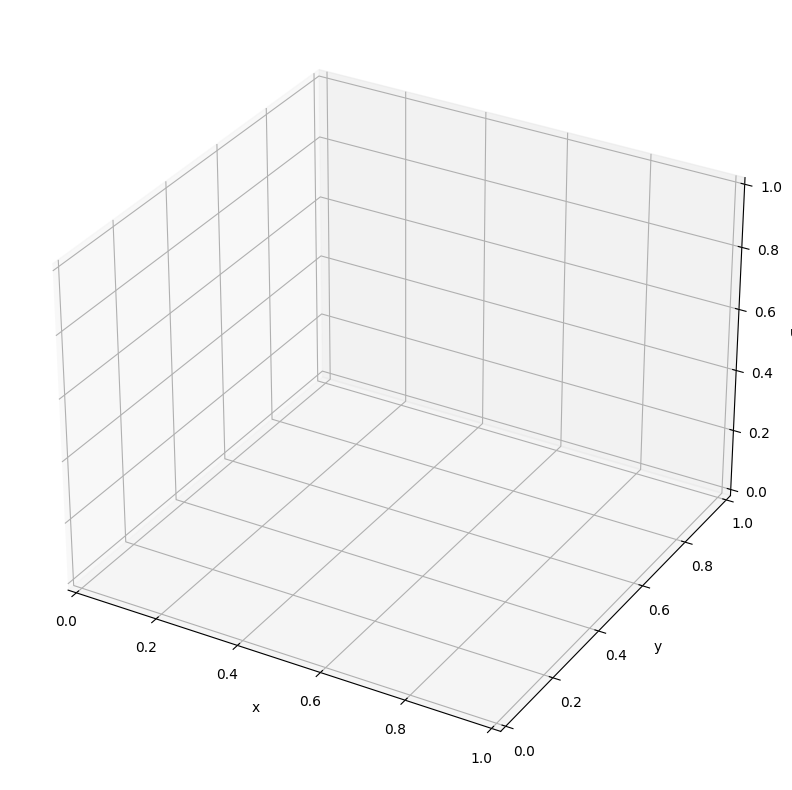

In [ ]:
# eg 8.14 ~ program 8.8: fisher 2d w bdm,mni

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.set_printoptions(precision=6,suppress=True)

# ic,bc
f = lambda x,y: 2 + np.cos(np.pi*x)*np.cos(np.pi*y) # lowercase!!

# som parms
D = 1
imax = 3 # max multivate newtons iterations # value per sauer

# intervals
x,y,t = [0,1],[0,1],[0,5]
# subintervals, steps
M = 20
N = 20
nt = 100 # t
h = (x[1]-x[0])/M
k = (y[1]-y[0])/N
dt = (t[1]-t[0])/nt
# mesh
m = M+1   # x-size
n = N+1   # y-size
mn = m*n  # translation dimension
xs = np.linspace(x[0],x[1],m)
ys = np.linspace(y[0],y[1],n)
h2,k2 = pow(h,2),pow(k,2) # for convenience

# plot, initialize here
it_plot = (t[1]-t[0])/(6-1) # 6 maximum plots to capture over time [0,5]
fig,axs = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':'3d'})
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.set_zlabel("u")

# ws at initial time
ws = np.zeros((m,n))
for i in range(m):
  for j in range(n):
    ws[i,j] = f(xs[i],ys[j])

# calc mesh at time step
for it in range(nt):
  vs = np.zeros((mn,1)) # translated workspace
  vs = ws.reshape(vs.shape)
  ws_old = np.copy(ws)

  for inm in range(imax): # newtons multivariate
    # DF,b
    DF1,DF2 = np.zeros((mn,mn)),np.zeros((mn,mn))
    b = np.zeros((mn,1))
    # interior
    for i in range(1,m-1):
      for j in range(1,n-1):
        DF1[i+j*m,i-1+ j   *m] = DF1[i+j*m,i+1+ j   *m] = -D/h2
        DF1[i+j*m,i  + j   *m] = 2*D/h2 + 2*D/k2 - 1 - 1/dt
        DF1[i+j*m,i  +(j-1)*m] = DF1[i+j*m,i  +(j+1)*m] = -D/k2
        b[i+j*m] = -ws_old[i,j]/dt
        DF2[i+j*m,i   +j   *m] = 2*ws[i,j]
    # boundary
    for i in range(m): # all points
      # bottom, j = 0
      j =   0;
      DF1[i+j*m,i+ j   *m] =  3;
      DF1[i+j*m,i+(j+1)*m] = -4;
      DF1[i+j*m,i+(j+2)*m] =  1;
      # top, j = n-1
      j = n-1;
      DF1[i+j*m,i+ j   *m] =  3;
      DF1[i+j*m,i+(j-1)*m] = -4;
      DF1[i+j*m,i+(j-2)*m] =  1;
    for j in range(1,n-1): # all but first and last
      # left, i = 0
      i =   0;
      DF1[i+j*m,i  +j*m] =  3;
      DF1[i+j*m,i+1+j*m] = -4;
      DF1[i+j*m,i+2+j*m] =  1;
      # right, i = m-1
      i = m-1;
      DF1[i+j*m,i  +j*m] =  3;
      DF1[i+j*m,i-1+j*m] = -4;
      DF1[i+j*m,i-2+j*m] =  1;

    DF,F = np.zeros((mn,mn)),np.zeros((mn,1))
    DF = DF1 + DF2
    dF = DF1 + DF2/2
    F  = np.dot(DF1 + DF2/2,vs) + b
    vs = vs - np.linalg.solve(DF,F) # DF,F same as matlab but vs ++different
    ws = vs.reshape(ws.shape)

  # plot ONE ~ way longer than matlab and not even animated; mebbe fix later
  if False and ((it ==0 )):# or ((it+1) % it_plot == 0)):
    if(it==0):
      print(f"it {it}")
      print("\n TL")
      print(ws_old[:5,:5])
      print(ws[:5,:5])
      print("\n TR")
      print(ws_old[-5:,:5])
      print(ws[-5:,:5])
      print("\n LL")
      print(ws_old[:5,-5:])
      print(ws[:5,-5:])
      print("\n LR")
      print(ws_old[-5:,-5:])
      print(ws[-5:,-5:])
    x,y = np.meshgrid(xs,ys) #,indexing='ij') # sauers algorithm uses cartesian

    axs.set_title("fdm, h="+str(h)+",k="+str(k))
    axs.plot_surface(x,y,ws)

    for angle in range(0,360):
      axs.view_init(elev=45,azim=225,roll=0)

    fig.canvas.draw()
    fig.canvas.flush_events()


###### usw


which goes a little something like this. ah, and this is an animation, from (a) to (b).
</br>


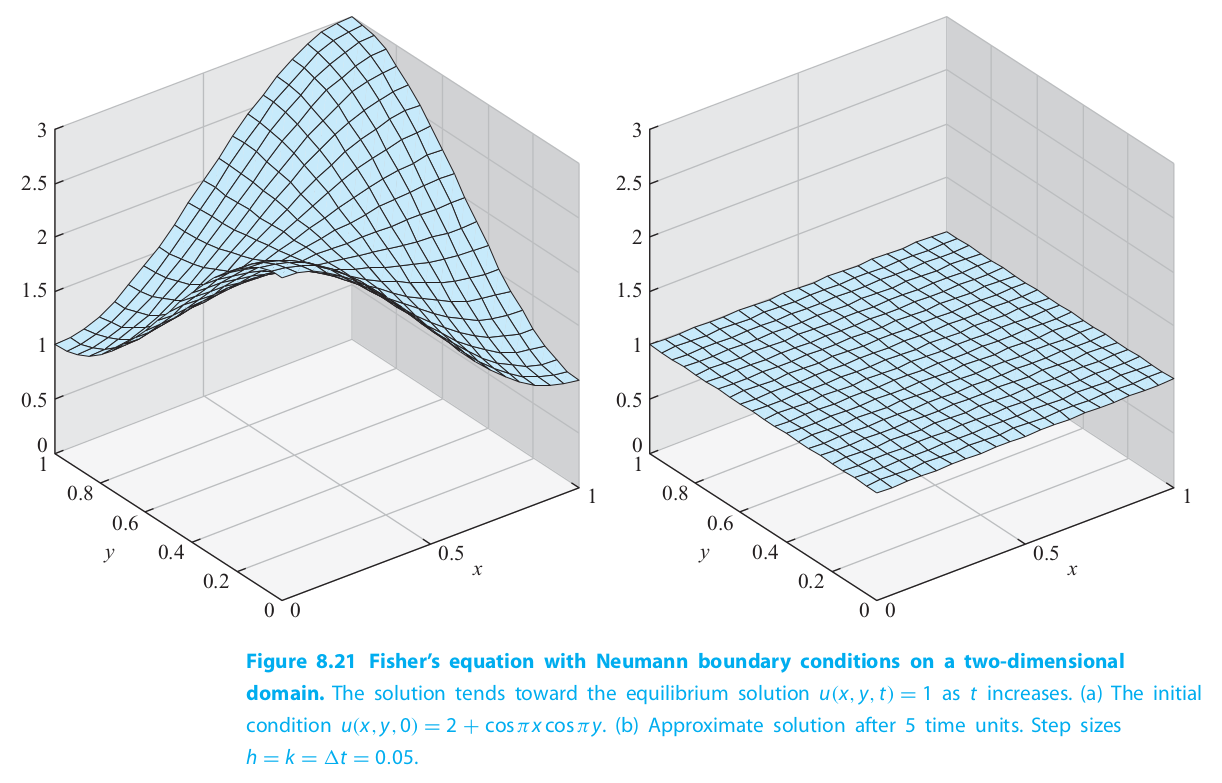

###### example 15



###### backstory

mathematician [alan turing](https://en.wikipedia.org/wiki/Alan_Turing) proposed an explanation for shapes and structures found in the natural world. certain reaction-diffusion equations demonstrated emergent order and are now known as [turing patterns](https://en.wikipedia.org/wiki/Turing_pattern). turing found that adding a diffusion term to a stable chemical reaction caused instability. this [turing instability](https://en.wikipedia.org/wiki/Reaction%E2%80%93diffusion_system#Two-component_reaction%E2%80%93diffusion_equations) causes a transition where patterns might evolve into a new, spatially varying steady-state. the [brusselator](https://en.wikipedia.org/wiki/Brusselator) model (ilya prigogine [link text](https://en.wikipedia.org/wiki/Ilya_Prigogine)) consists of two coupled PDEs that each represent one species of a two-species chemical reaction.
</br>


apply BDM and NMI to brusselator equation with homogeneous neumann boundary conditions on $[0,40]\times [0,40]$
</br></br>

$$
\quad\left\{
  \begin{array}{l}
    p_t = D_p\Delta p + p^2q + C - (K+1)p \\
    q_t = D_p\Delta q - p^2q + Kp \\
    \\
    p(x,y,0) = C + 0.1 \quad 0\le x,y\le 40 \\
    q(x,y,0) = \frac{K}{C} + 0.2 \quad 0\le x,y\le 40 \\
    u_{\vec{n}}(x,y,t) = 0 \quad \text{on boundary, } t\ge 0
  \end{array}
\right.
$$
</br>

ie, two coupled equations of variables $p,q$, diffusion coefficients $D_p,D_q$ and parameters $C,K > 0$. equilibrium at $p\equiv C, q\equiv \frac{K}{C}$. it is known that equilibrium is stable for small $K$ and that a turing instability occurs when
</br></br>

$$K > \left( 1 + C\sqrt{\frac{D_p}{D_q}} \right)^2.$$
</br>


at interior points, $1<i<m,1<j<n$,
</br></br>

\begin{align}
  \frac{p_{ij}^t - p_{ij}^{t-\Delta t}}{\Delta t} - \frac{D_p}{h^2}(p_{i+1,j}^t - 2p_{ij}^t + p_{i-1,j}^t) - \frac{D_p}{k^2}(p_{i,j+1}^t - 2p_{ij}^t + p_{i,j-1}^t) - (p_{ij}^t)^2q_{ij}^t - C +(K+1)p_{ij}^t = 0 \\
  \frac{q_{ij}^t - q_{ij}^{t-\Delta t}}{\Delta t} - \frac{D_q}{h^2}(q_{i+1,j}^t - 2q_{ij}^t + q_{i-1,j}^t) - \frac{D_q}{k^2}(q_{i,j+1}^t - 2q_{ij}^t + q_{i,j-1}^t) - (q_{ij}^t)^2q_{ij}^t - C +(K+1)q_{ij}^t = 0
\end{align}
</br>

note: this is the first example with coupled variables. also,
</br></br>

\begin{align}
  v_{i_(j-1)m} = p_{ij} &\quad 1\le i\le m, 1\le j\le n \\
  v_{mn_i+(j-1)m} = q_{ij} &\quad 1\le i\le m, 1\le j\le n .
\end{align}
</br>



###### code, matlab


[matlab online](https://matlab.mathworks.com)
</br></br>

```
% Program 09 Backward difference method with Newton iteration
% for the Brusselator
% input: space region [xl,xr]x[yb,yt], time interval [tb,te],
% M,N space steps in x and y directions, tsteps time steps
% output: solution mesh [x,y,w]
% Example usage: [x,y,p,q]=brusselator(0,40,0,40,0,20,40,40,20);
function [x,y,p,q]=brusselator(xl,xr,yb,yt,tb,te,M,N,tsteps)
  Dp=1;Dq=8;C=4.5;K=9;
  fp=@(x,y) C+0.1;
  fq=@(x,y) K/C+0.2;
  delt=(te-tb)/tsteps;
  m=M+1;n=N+1;mn=m*n;mn2=2*mn;
  h=(xr-xl)/M;k=(yt-yb)/N;
  x=linspace(xl,xr,m);y=linspace(yb,yt,n);
  %Define initial conditions
  for i=1:m
    for j=1:n
      p(i,j)=fp(x(i),y(j));
      q(i,j)=fq(x(i),y(j));
    end
  end
  for tstep=1:tsteps
    v=[reshape(p,mn,1);reshape(q,mn,1)];
    pold=p;qold=q;
    for it=1:3
      DF1=zeros(mn2,mn2);DF3=zeros(mn2,mn2);
      b=zeros(mn2,1);
      for i=2:m-1
        for j=2:n-1
          DF1(i+(j-1)*m,i-1+(j-1)*m)=-Dp/h^2;
          DF1(i+(j-1)*m,i+(j-1)*m)= Dp*(2/h^2+2/k^2)+K+1+1/(1*delt);
          DF1(i+(j-1)*m,i+1+(j-1)*m)=-Dp/h^2;
          DF1(i+(j-1)*m,i+(j-2)*m)=-Dp/k^2;
          DF1(i+(j-1)*m,i+j*m)=-Dp/k^2;
          b(i+(j-1)*m)=-pold(i,j)/(1*delt)-C;
          DF1(mn+i+(j-1)*m,mn+i-1+(j-1)*m)=-Dq/h^2;
          DF1(mn+i+(j-1)*m,mn+i+(j-1)*m)= Dq*(2/h^2+2/k^2)+1/(1*delt);
          DF1(mn+i+(j-1)*m,mn+i+1+(j-1)*m)=-Dq/h^2;
          DF1(mn+i+(j-1)*m,mn+i+(j-2)*m)=-Dq/k^2;
          DF1(mn+i+(j-1)*m,mn+i+j*m)=-Dq/k^2;
          DF1(mn+i+(j-1)*m,i+(j-1)*m)=-K;
          DF3(i+(j-1)*m,i+(j-1)*m)=-2*p(i,j)*q(i,j);
          DF3(i+(j-1)*m,mn+i+(j-1)*m)=-p(i,j)^2;
          DF3(mn+i+(j-1)*m,i+(j-1)*m)=2*p(i,j)*q(i,j);
          DF3(mn+i+(j-1)*m,mn+i+(j-1)*m)=p(i,j)^2;
          b(mn+i+(j-1)*m)=-qold(i,j)/(1*delt);
        end
      end
      % bottom and top Neumann conditions
      for i=1:m
        j=1;DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+j*m)=-4;
        DF1(i+(j-1)*m,i+(j+1)*m)=1;
        j=n;DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+(j-2)*m)=-4;
        DF1(i+(j-1)*m,i+(j-3)*m)=1;
        j=1;DF1(mn+i+(j-1)*m,mn+i+(j-1)*m)=3;
        DF1(mn+i+(j-1)*m,mn+i+j*m)=-4;
        DF1(mn+i+(j-1)*m,mn+i+(j+1)*m)=1;
        j=n;DF1(mn+i+(j-1)*m,mn+i+(j-1)*m)=3;
        DF1(mn+i+(j-1)*m,mn+i+(j-2)*m)=-4;
        DF1(mn+i+(j-1)*m,mn+i+(j-3)*m)=1;
      end
      %left and right Neumann conditions
      for j=2:n-1
        i=1;DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i+1+(j-1)*m)=-4;
        DF1(i+(j-1)*m,i+2+(j-1)*m)=1;
        i=m;DF1(i+(j-1)*m,i+(j-1)*m)=3;
        DF1(i+(j-1)*m,i-1+(j-1)*m)=-4;
        DF1(i+(j-1)*m,i-2+(j-1)*m)=1;
        i=1;DF1(mn+i+(j-1)*m,mn+i+(j-1)*m)=3;
        DF1(mn+i+(j-1)*m,mn+i+1+(j-1)*m)=-4;
        DF1(mn+i+(j-1)*m,mn+i+2+(j-1)*m)=1;
        i=m;DF1(mn+i+(j-1)*m,mn+i+(j-1)*m)=3;
        DF1(mn+i+(j-1)*m,mn+i-1+(j-1)*m)=-4;
        DF1(mn+i+(j-1)*m,mn+i-2+(j-1)*m)=1;
      end
      DF=DF1+DF3;
      F=(DF1+DF3/3)*v+b;
      v=v-DF\F;
      p=reshape(v(1:mn),m,n);q=reshape(v(mn+1:mn2),m,n);
    end
    contour(x,y,p);drawnow;
  end
end
```



###### code, python


bc the previous code had issues with large matrix operations, this one may as well. i probably wont update that script or this one this month, but for interested parties, i will have it available somewhere findable before next semester.
</br>


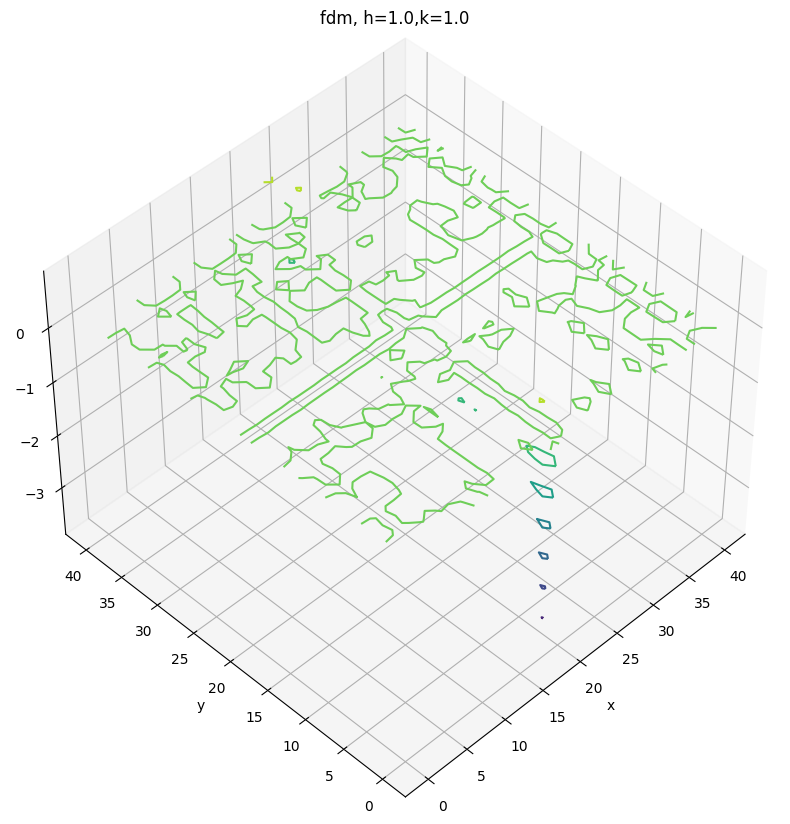

In [ ]:
# example 15 ~ program 09 BDM,MNI for brusselator

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.set_printoptions(precision=6,suppress=True)

# ic,bc
Fp = lambda x,y: C + 0.1
Fq = lambda x,y: K/C + 0.2

# som parms
Dp,Dq = 1,8;
C,K = 4.5,9
imax = 3 # max multivate newtons iterations # value per sauer

# intervals
x,y,t = [0,40],[0,40],[0,20]
# subintervals, steps
M = 40
N = 40
nt = 20 # t
h = (x[1]-x[0])/M
k = (y[1]-y[0])/N
dt = (t[1]-t[0])/nt
# mesh
m = M+1   # x-size
n = N+1   # y-size
mn = m*n  # translation dimension
mn2 = 2*mn  # convenience
xs = np.linspace(x[0],x[1],m)
ys = np.linspace(y[0],y[1],n)
h2,k2 = pow(h,2),pow(k,2) # convenience

# plot, initialize here
ixplots,iyplots = 2,3
it_plotevery = (t[1]-t[0])/(ixplots*iyplots-1) # matlab plots at each dt but too much;
#fig,axs = plt.subplots(ixplots,iyplots,figsize=(10,10),subplot_kw={'projection':'3d'})
fig,axs = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':'3d'})
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.set_zlabel("p")

# ws at initial time
wp = np.zeros((m,n))
wq = np.zeros((m,n))
for i in range(m):
  for j in range(n):
    wp[i,j] = Fp(xs[i],ys[j])
    wq[i,j] = Fq(xs[i],ys[j])

# calc mesh at time step
for it in range(nt):
  vs = np.zeros((mn2,1)) # translated workspace
  vs = np.concatenate((wp,wq)).reshape(vs.shape)
  wp_old,wq_old = np.copy(wp),np.copy(wq)

  for inm in range(imax): # newtons multivariate
    # DF,b
    DF1,DF3 = np.zeros((mn2,mn2)),np.zeros((mn2,mn2))
    b = np.zeros((mn2,1))

    # interior
    for i in range(1,m-1):
      for j in range(1,n-1):
        DF1[i+j*m,i-1+ j   *m] = DF1[i+j*m,i+1+ j   *m] = -Dp/h2
        DF1[i+j*m,i  + j   *m] = Dp*(2/h2 + 2/k2) + K + 1 + 1/dt
        DF1[i+j*m,i  +(j-1)*m] = DF1[i+j*m,i  +(j+1)*m] = -Dp/k2

        DF1[mn+i+ j   *m,mn+i-1+ j   *m] = DF1[mn+i+ j   *m,mn+i+1+ j   *m] = -Dq/h2
        DF1[mn+i+ j   *m,mn+i  + j   *m] = Dq*(2/h2 + 2/k2) + 1/dt
        DF1[mn+i+ j   *m,mn+i  +(j-1)*m] = DF1[mn+i+ j   *m,mn+i  +(j+1)*m] = -Dq/k2
        DF1[mn+i+ j   *m,   i  + j   *m] = -K

        DF3[   i+j*m,   i+j*m] = -2*wp[i,j]*wq[i,j]
        DF3[   i+j*m,mn+i+j*m] = -pow(wp[i,j],2)
        DF3[mn+i+j*m,   i+j*m] =  2*wp[i,j]*wq[i,j]
        DF3[mn+i+j*m,mn+i+j*m] =  pow(wp[i,j],2)

        b[   i+ j   *m] = -wp_old[i,j]/dt - C
        b[mn+i+(j-1)*m] = -wq_old[i,j]/dt

    # boundary
    for i in range(m): # all points
      # bottom, j = 0
      j =   0;
      DF1[   i+j*m,   i+ j   *m] =  3;
      DF1[   i+j*m,   i+(j+1)*m] = -4;
      DF1[   i+j*m,   i+(j+2)*m] =  1;
      DF1[mn+i+j*m,mn+i+ j   *m] =  3;
      DF1[mn+i+j*m,mn+i+(j+1)*m] = -4;
      DF1[mn+i+j*m,mn+i+(j+2)*m] =  1;

      # top, j = n-1
      j = n-1;
      DF1[   i+j*m,   i+ j   *m] =  3;
      DF1[   i+j*m,   i+(j-1)*m] = -4;
      DF1[   i+j*m,   i+(j-2)*m] =  1;
      DF1[mn+i+j*m,mn+i+ j   *m] =  3;
      DF1[mn+i+j*m,mn+i+(j-1)*m] = -4;
      DF1[mn+i+j*m,mn+i+(j-2)*m] =  1;

    for j in range(1,n-1): # all but first and last
      # left, i = 0
      i =   0;
      DF1[   i+j*m,   i  +j*m] =  3;
      DF1[   i+j*m,   i+1+j*m] = -4;
      DF1[   i+j*m,   i+2+j*m] =  1;
      DF1[mn+i+j*m,mn+i  +j*m] =  3;
      DF1[mn+i+j*m,mn+i+1+j*m] = -4;
      DF1[mn+i+j*m,mn+i+2+j*m] =  1;

      # right, i = m-1
      i = m-1;
      DF1[   i+j*m,   i  +j*m] =  3;
      DF1[   i+j*m,   i-1+j*m] = -4;
      DF1[   i+j*m,   i-2+j*m] =  1;
      DF1[mn+i+j*m,mn+i  +j*m] =  3;
      DF1[mn+i+j*m,mn+i-1+j*m] = -4;
      DF1[mn+i+j*m,mn+i-2+j*m] =  1;

    DF,F = np.zeros_like(DF1),np.zeros_like(b)
    DF = DF1 + DF3
    F  = np.dot(DF1 + DF3/3,vs) + b
    vs = vs - np.linalg.solve(DF,F) # DF,F same as matlab but vs ++different

    wp = np.reshape(vs[0:mn],wp.shape)
    wq = np.reshape(vs[mn:mn2],wq.shape)

  # plot ONE ~ way longer than matlab and not even animated; mebbe fix later
  if True and ((it ==0 )):# or ((it+1) % it_plotevery == 0)):
    x,y = np.meshgrid(xs,ys) #,indexing='ij') # sauers algorithm uses cartesian

    axs.set_title("fdm, h="+str(h)+",k="+str(k))
    axs.contour(x,y,wp)

    for angle in range(0,360):
      axs.view_init(elev=45,azim=225,roll=0)

    fig.canvas.draw()
    fig.canvas.flush_events()


###### usw


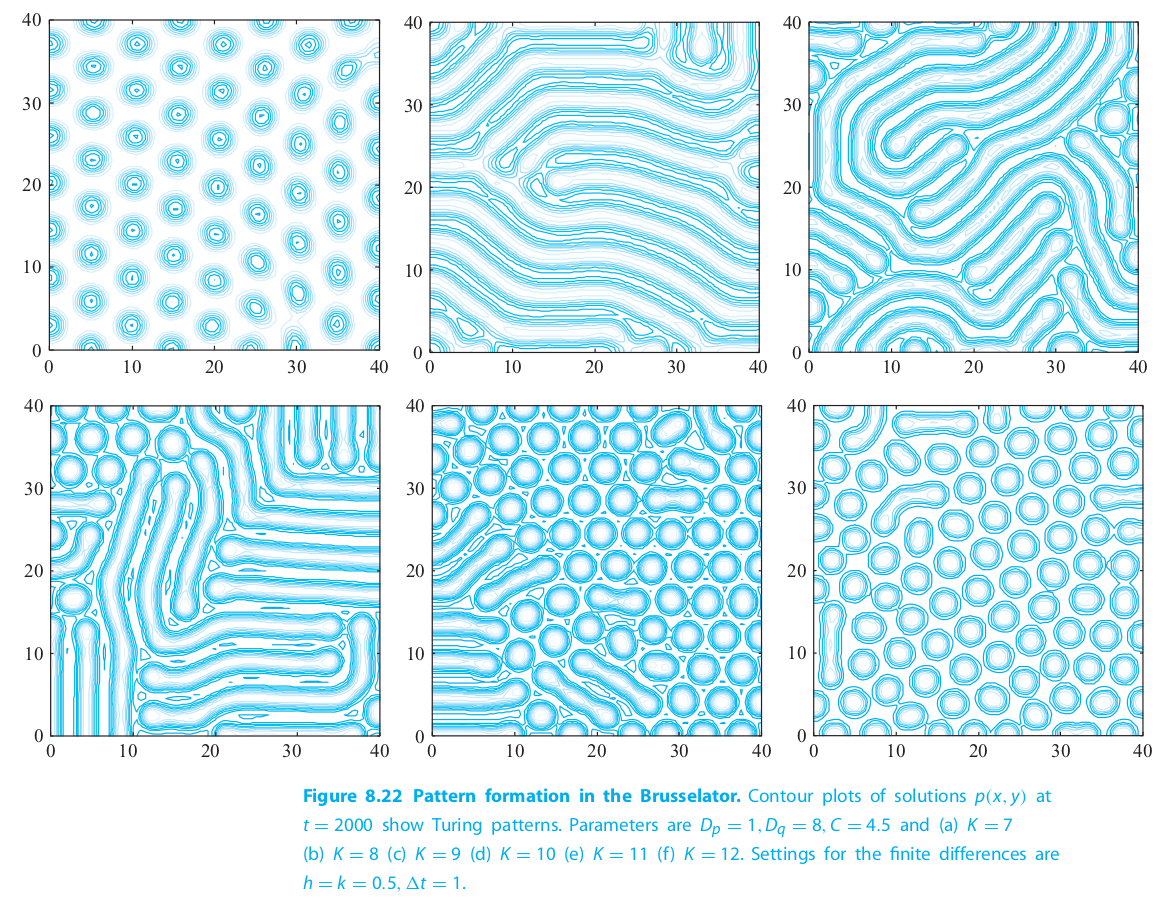

*   an alternative brusselator: [alt](https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_brusselator_expression.html).
</br></br>


you will likely need to run this in a notebook cell for the above to run.

```
pip install py-pde h5py pyfftw tqdm
```
</br>

*   a less tedious example: [turing patterns](https://ipython-books.github.io/124-simulating-a-partial-differential-equation-reaction-diffusion-systems-and-turing-patterns/).
</br>
